#### zona install command

In [1]:
#!pip install prophet

#### Import delle librerie

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


#### Carico i dati della provincia (Lombardia)

In [3]:
# URL CSV nazionale per tutte le regioni 
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"

# Carico e filtro solo la Lombardia
df = pd.read_csv(url, parse_dates=['data'])
df_lombardia = df[df['denominazione_regione'] == 'Lombardia'].copy()

# Visualizza le prime righe
df_lombardia[['data', 'terapia_intensiva']].head()

#carico il file scaricato (si trova nello stesso percorso dello script)
df_istat = pd.read_csv("Posti letto_centomila.csv", sep=";")
#print(df_istat.rpow) #stampa le righe file dell'ISTAT
#filtro lomabrdia
df_lombardia_letti= df_istat[df_istat["REF_AREA"]=="ITC4"]
#print(df_istat.columns)
#df_istat.head()
posti_letto=df_lombardia_letti["Osservazione"].values[0]  #qui ho i posti letto della lomabardia
print(f"Posti letto TI Lombardia (da ISTAT): {posti_letto}")
print(df.columns)


Posti letto TI Lombardia (da ISTAT): 860.1
Index(['data', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido', 'codice_nuts_1', 'codice_nuts_2'],
      dtype='object')


#### calcolo la percentuale di occuazione

In [4]:
df_lombardia['occupazione_percento'] = (df_lombardia['terapia_intensiva'] / posti_letto) * 100 #creo una nuova colonna occupazione_percento
df_2021 = df_lombardia[df_lombardia['data'].dt.year == 2021]

df_2021['occupazione_smooth'] = df_2021['occupazione_percento'].rolling(window=7).mean()

C:\Users\mathi\AppData\Local\Temp\ipykernel_17148\3487913739.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021['occupazione_smooth'] = df_2021['occupazione_percento'].rolling(window=7).mean()


#### alleno il modello e faccio una previsione

In [ ]:
# Preparo i dati (ho aggiunto i positivi per aiutare ad allenare il modello)
df_prophet = df_2021[['data','totale_positivi', 'terapia_intensiva']].rename(columns={'data': 'ds','totale_positivi':'pos', 'terapia_intensiva': 'y'})
df_prophet['cap']=posti_letto
df_prophet= df_prophet[df_prophet['ds']<='2022-01-01']
print("Inizio dati training:", df_prophet['ds'].min())
print("Fine dati training:", df_prophet['ds'].max())


print("Numero di giorni:", len(df_prophet))

df_controllo_30=df_lombardia[['data', 'terapia_intensiva']].rename(columns={'data': 'ds', 'terapia_intensiva': 'y'}) #controllo i 30gg previsti
df_controllo_30['occupazione_percento']=(df_controllo_30['y'] / posti_letto) * 100

#creo e addestro il modello
model= Prophet(seasonality_mode='additive', yearly_seasonality=False,weekly_seasonality=False, daily_seasonality=False)#, yearly_seasonality=False,weekly_seasonality=False, daily_seasonality=False, growth = 'logistic')
model.add_regressor('pos')

model.fit(df_prophet)


#creo i dati futuri
futuro=model.make_future_dataframe(periods=30)
# Estraggo la serie dei positivi usata nel training----------------------------------
serie_pos = df_prophet['pos']
# Prendo l'ultimo valore noto (per i giorni futuri)
ultimo_valore_pos = serie_pos.iloc[-1]
# Aggiungi la colonna 'pos' al DataFrame futuro
# - Parte storica → gli stessi valori del training
# - Parte futura  → stesso valore dell'ultimo giorno noto
futuro['pos'] = list(serie_pos) + [ultimo_valore_pos] * (len(futuro) - len(serie_pos))
#-------------------------------------------------------------------------------------


previsione= model.predict(futuro)


# Calcola percentuale di occupazione prevista
previsione['occupazione_percento'] = (previsione['yhat'] / posti_letto) * 100

inizio_previsione = df_prophet['ds'].max()
data_inizio_controllo = inizio_previsione-pd.Timedelta(days=5)
data_fine_controllo = inizio_previsione + pd.Timedelta(days=30)
print(data_inizio_controllo,data_fine_controllo)
df_reali_30gg = df_controllo_30[(df_controllo_30['ds'] > data_inizio_controllo) & (df_controllo_30['ds'] <= data_fine_controllo)]

19:33:22 - cmdstanpy - INFO - Chain [1] start processing


Inizio dati training: 2021-01-01 17:00:00
Fine dati training: 2021-12-31 17:00:00
Numero di giorni: 365


19:33:22 - cmdstanpy - INFO - Chain [1] done processing


2021-12-26 17:00:00 2022-01-30 17:00:00


#### Mostro il grafico di occupazione

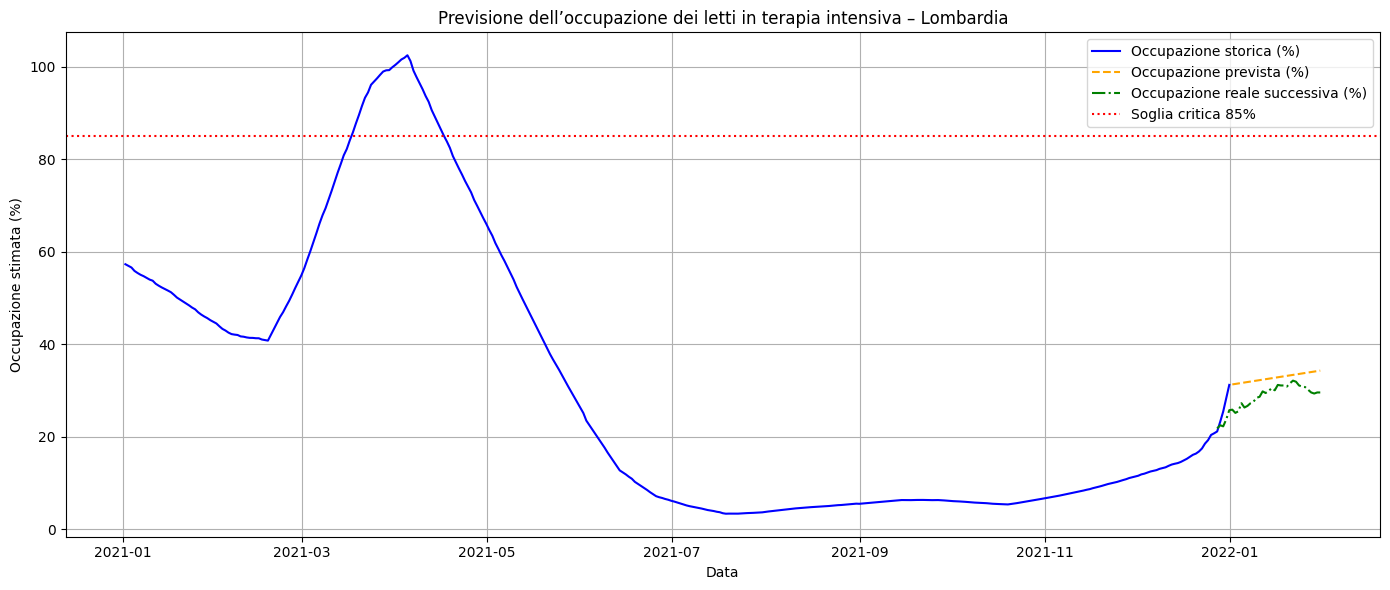

In [11]:
# plt.figure(figsize=(12,6)) # grandezza dell'intera immagine
# plt.plot(df_2021['data'], df_2021['occupazione_percento'], label='Occupazione TI %', color='blue')
# plt.axhline(85, color='red', linestyle='--', label='Soglia critica 85%')
# plt.title('Occupazione stimata dei posti letto in TI – Lombardia (2021)')
# plt.xlabel('Data')
# plt.ylabel('Occupazione (%)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.plot(df_2021['data'], df_2021['occupazione_smooth'], label='Media mobile 7gg', color='green')

# plt.show()
#--------mostro il modello predittivo-------------------------------------------------

# fig = model.plot(previsione)
# plt.title("Previsione ricoveri in TI – Lombardia")
# plt.grid(True)
# plt.tight_layout()

#--------mostro il modello MIXATO-------------------------------------------------

# Creo un flag per distinguere dati reali e previsti
previsione['tipo'] = ['storico' if date <= df_prophet['ds'].max() else 'previsto' for date in previsione['ds']]
# Grafico
plt.figure(figsize=(14,6))

# Linea storica
plt.plot(previsione[previsione['tipo'] == 'storico']['ds'],
         previsione[previsione['tipo'] == 'storico']['occupazione_percento'],
         label='Occupazione storica (%)', color='blue')

# Linea prevista
plt.plot(previsione[previsione['tipo'] == 'previsto']['ds'],
         previsione[previsione['tipo'] == 'previsto']['occupazione_percento'],
         label='Occupazione prevista (%)', color='orange', linestyle='--')

# Linea dati reali successivi
plt.plot(df_reali_30gg['ds'],
         df_reali_30gg['occupazione_percento'],
         label='Occupazione reale successiva (%)', color='green', linestyle='-.')

# Soglia critica
plt.axhline(85, color='red', linestyle=':', label='Soglia critica 85%')
# Etichette
plt.title("Previsione dell’occupazione dei letti in terapia intensiva – Lombardia")
plt.xlabel("Data")
plt.ylabel("Occupazione stimata (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()


plt.show()

